# Scalability analysis (strong scaling)

This notebook analyzes MPI scalability for both time integrators using the CSV produced by the scalability script:

- Input: `scalability-results.csv`
- Metrics: wall time, speedup, efficiency

Speedup and efficiency are computed **per configuration** `(scheme, Nel, R, Dt, T)` using the `nprocs=1` timing as baseline.

Crank-Nicolson for the Theta method. beta=0.25, gamma=0.5 for Newmark.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

In [2]:
csv_path = Path('scalability-results-all.csv')
df = pd.read_csv(csv_path)

# Basic cleanup / typing
df = df.copy()
df['nprocs'] = pd.to_numeric(df['nprocs'], errors='coerce')
df['Nel'] = pd.to_numeric(df['Nel'], errors='coerce')
df['R'] = pd.to_numeric(df['R'], errors='coerce')
df['Dt'] = pd.to_numeric(df['Dt'], errors='coerce')
df['T'] = pd.to_numeric(df['T'], errors='coerce')
df['seconds'] = pd.to_numeric(df['seconds'], errors='coerce')
df['returncode'] = pd.to_numeric(df['returncode'], errors='coerce')

# Keep only successful runs with valid timing
df = df[(df['returncode'] == 0) & df['seconds'].notna() & (df['seconds'] > 0)].copy()

# If duplicates exist, keep the minimum time (best run) for the same setting
dedup_keys = ['scheme', 'binary', 'nprocs', 'Nel', 'R', 'Dt', 'T', 'Theta', 'Beta', 'Gamma']
df = df.sort_values('seconds').drop_duplicates(subset=dedup_keys, keep='first')

df.head()

,scheme,binary,nprocs,repeat,Nel,R,Dt,T,Theta,Beta,Gamma,returncode,seconds
84,newmark-0.00,/scratch_local/nmpde-wave-equation_9422.login0...,32,1,640,1,0.0008,0.5,NaN,0.0,0.5,0,9.993134
176,newmark-0.00,/scratch_local/nmpde-wave-equation_9420.login0...,32,3,640,1,0.0008,0.5,NaN,0.0,0.5,0,10.190990
160,newmark-0.00,/scratch_local/nmpde-wave-equation_9420.login0...,16,2,640,1,0.0008,0.5,NaN,0.0,0.5,0,12.317912
69,newmark-0.00,/scratch_local/nmpde-wave-equation_9422.login0...,16,1,640,1,0.0008,0.5,NaN,0.0,0.5,0,12.403002
146,newmark-0.00,/scratch_local/nmpde-wave-equation_9420.login0...,8,3,640,1,0.0008,0.5,NaN,0.0,0.5,0,20.263796


In [3]:
# Compute strong-scaling speedup/efficiency per configuration (scheme + discretization + final time)
group_keys = ['scheme', 'Nel', 'R', 'Dt', 'T', 'Theta', 'Beta', 'Gamma']

# Baseline timings (nprocs == 1) per configuration
base = (
    df[df['nprocs'] == 1][group_keys + ['seconds']]
    .rename(columns={'seconds': 't_base'})
    .groupby(group_keys, dropna=False, as_index=False)['t_base'].min()
)

# Join baseline back and compute metrics (vectorized, no GroupBy.apply => no warning)
dfm = df.merge(base, on=group_keys, how='left')
dfm = dfm[dfm['t_base'].notna()].copy()
dfm['speedup'] = dfm['t_base'] / dfm['seconds']
dfm['efficiency'] = dfm['speedup'] / dfm['nprocs']

dfm[['scheme', 'nprocs', 'Nel', 'R', 'Dt', 'T', 'seconds', 'speedup', 'efficiency']].sort_values(['scheme','Nel','Dt','T','nprocs']).head(20)

,scheme,nprocs,Nel,R,Dt,T,seconds,speedup,efficiency
36,newmark-0.00,1,640,1,0.0008,0.5,116.517860,1.000000,1.000000
39,newmark-0.00,1,640,1,0.0008,0.5,133.776495,0.870989,0.870989
28,newmark-0.00,2,640,1,0.0008,0.5,61.892394,1.882588,0.941294
29,newmark-0.00,2,640,1,0.0008,0.5,74.547363,1.563004,0.781502
14,newmark-0.00,4,640,1,0.0008,0.5,33.754097,3.451962,0.862990
19,newmark-0.00,4,640,1,0.0008,0.5,41.391503,2.815019,0.703755
4,newmark-0.00,8,640,1,0.0008,0.5,20.263796,5.750051,0.718756
5,newmark-0.00,8,640,1,0.0008,0.5,20.280764,5.745240,0.718155
2,newmark-0.00,16,640,1,0.0008,0.5,12.317912,9.459222,0.591201
3,newmark-0.00,16,640,1,0.0008,0.5,12.403002,9.394327,0.587145


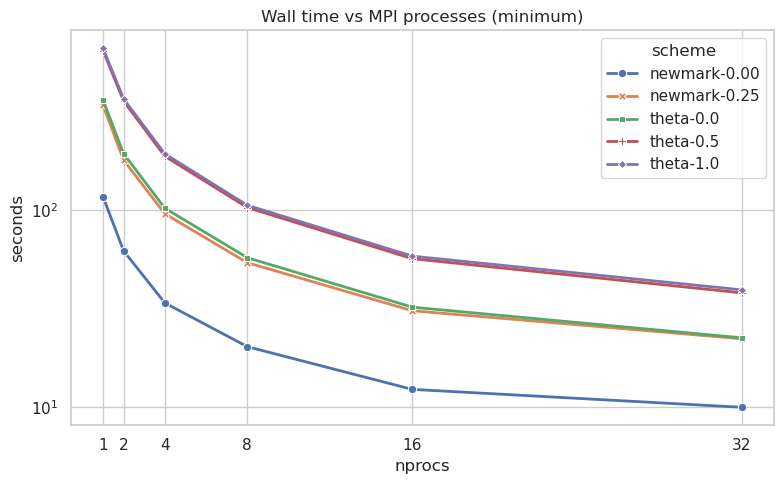

In [4]:
# Runtime vs nprocs (one curve per scheme per (Nel,Dt,T) setting if multiple exist)
plot_keys = ['scheme', 'Nel', 'R', 'Dt', 'T']
df_plot = dfm.copy()

# Build a label for the discretization/time config
df_plot['case'] = (
    'Nel=' + df_plot['Nel'].astype(int).astype(str)
    + ', R=' + df_plot['R'].astype(int).astype(str)
    + ', Dt=' + df_plot['Dt'].astype(str)
    + ', T=' + df_plot['T'].astype(str)
)

# Aggregate by taking minimum for each configuration
df_plot_agg = df_plot.groupby(['scheme', 'nprocs'], as_index=False).agg({'seconds': 'min'})

plt.figure(figsize=(8, 5))
ax = sns.lineplot(
    data=df_plot_agg, x='nprocs', y='seconds',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    errorbar=None
)
ax.set_title('Wall time vs MPI processes (minimum)')
ax.set_xlabel('nprocs')
ax.set_ylabel('seconds')
ax.set_yscale('log')
ax.set_xticks(sorted(df_plot_agg['nprocs'].unique()))
plt.tight_layout()

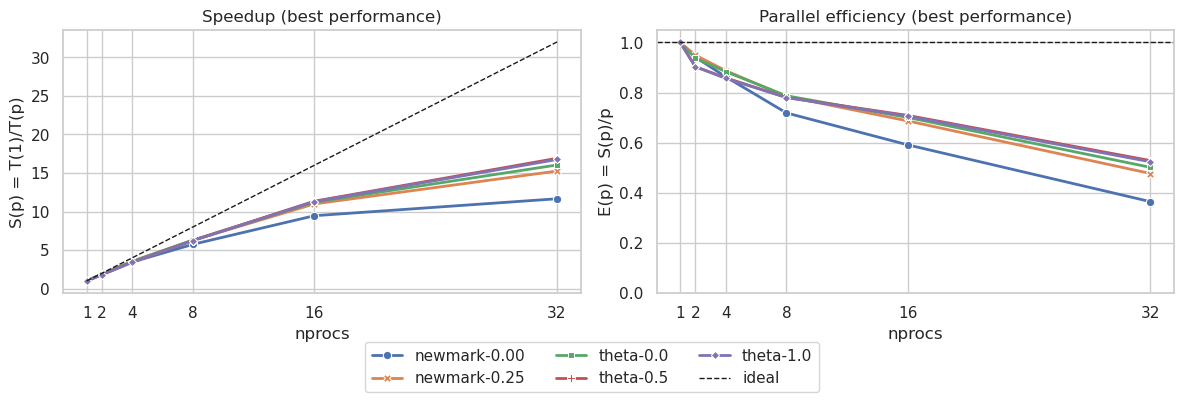

In [10]:
# Speedup and efficiency vs nprocs
# Aggregate by taking minimum for each configuration
dfm_agg = dfm.groupby(['scheme', 'nprocs'], as_index=False).agg({
    'speedup': 'max',  # max speedup corresponds to min time
    'efficiency': 'max'  # max efficiency corresponds to min time
})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    data=dfm_agg, x='nprocs', y='speedup',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[0], errorbar=None
)
axes[0].plot([1, dfm_agg['nprocs'].max()], [1, dfm_agg['nprocs'].max()], color='k', linewidth=1, linestyle='--', label='ideal')
axes[0].set_title('Speedup (best performance)')
axes[0].set_xlabel('nprocs')
axes[0].set_ylabel('S(p) = T(1)/T(p)')
axes[0].set_xticks(sorted(dfm_agg['nprocs'].unique()))

sns.lineplot(
    data=dfm_agg, x='nprocs', y='efficiency',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[1], errorbar=None
)
axes[1].axhline(1.0, color='k', linewidth=1, linestyle='--', label='ideal')
axes[1].set_title('Parallel efficiency (best performance)')
axes[1].set_xlabel('nprocs')
axes[1].set_ylabel('E(p) = S(p)/p')
axes[1].set_xticks(sorted(dfm_agg['nprocs'].unique()))
axes[1].set_ylim(0, max(1.05, float(dfm_agg['efficiency'].max()) * 1.05))

# De-duplicate legends (single legend outside)
handles, labels = axes[0].get_legend_handles_labels()
for ax in axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True, bbox_to_anchor=(0.5, -0.02))
fig.tight_layout(rect=[0, 0.08, 1, 1])

### Hardware context (Intel Xeon Gold 6238R × 2)
- 2 sockets, 28 cores/socket, 2 logical threads/core, 38.5 MB L3/socket
- 2 NUMA nodes (even CPUs → node 0, odd → node 1)


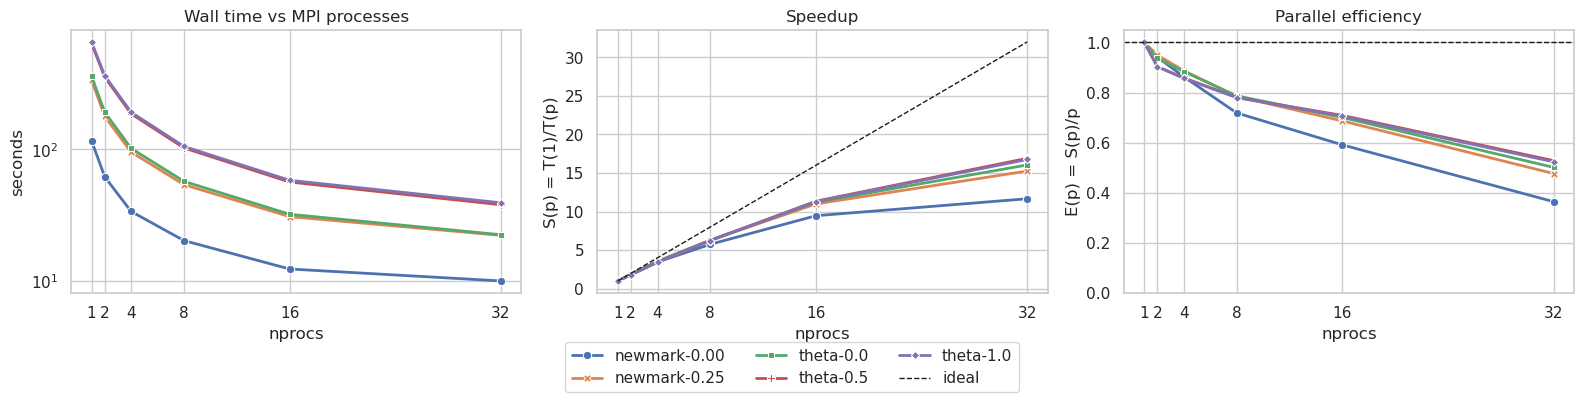

In [9]:
# Combined plot: Wall time, Speedup, and Efficiency
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1. Wall time
sns.lineplot(
    data=df_plot_agg, x='nprocs', y='seconds',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[0], errorbar=None
)
axes[0].set_title('Wall time vs MPI processes')
axes[0].set_xlabel('nprocs')
axes[0].set_ylabel('seconds')
axes[0].set_yscale('log')
axes[0].set_xticks(sorted(df_plot_agg['nprocs'].unique()))

# 2. Speedup
sns.lineplot(
    data=dfm_agg, x='nprocs', y='speedup',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[1], errorbar=None
)
axes[1].plot([1, dfm_agg['nprocs'].max()], [1, dfm_agg['nprocs'].max()], 
             color='k', linewidth=1, linestyle='--', label='ideal')
axes[1].set_title('Speedup')
axes[1].set_xlabel('nprocs')
axes[1].set_ylabel('S(p) = T(1)/T(p)')
axes[1].set_xticks(sorted(dfm_agg['nprocs'].unique()))

# 3. Efficiency
sns.lineplot(
    data=dfm_agg, x='nprocs', y='efficiency',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[2], errorbar=None
)
axes[2].axhline(1.0, color='k', linewidth=1, linestyle='--', label='ideal')
axes[2].set_title('Parallel efficiency')
axes[2].set_xlabel('nprocs')
axes[2].set_ylabel('E(p) = S(p)/p')
axes[2].set_xticks(sorted(dfm_agg['nprocs'].unique()))
axes[2].set_ylim(0, max(1.05, float(dfm_agg['efficiency'].max()) * 1.05))

# Single legend for all subplots
handles, labels = axes[1].get_legend_handles_labels()
for ax in axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True, bbox_to_anchor=(0.5, -0.02))
fig.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()